# Домашнее задание 1

In [1]:
import numpy as np
import requests
import random
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay

In [2]:
def load_url_content_to_file(url: str, filename: str):
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)

## Данные

Задания 1,2 выполните для сети:

In [3]:
load_url_content_to_file(
    url="https://drive.google.com/uc?id=1OKwRSPXs212Mzttg4D0GFFkiap-GztP_",
    filename = "Wiki-Vote.txt"
)

In [4]:
G=nx.read_edgelist('Wiki-Vote.txt',create_using=nx.DiGraph())
print('Nodes:',G.number_of_nodes()) # и выводим основные свойства
print('Edges:',G.number_of_edges())
print('Density:',nx.density(G))
print('Reciprocity:', nx.reciprocity(G))

Nodes: 7115
Edges: 103689
Density: 0.0020485375110809584
Reciprocity: 0.0564572905515532


## 1. Структурно-сетевые свойства направленной сети

### 1)  Распределение степеней (2 балла)
Постройте распределение степеней (in, out). Какой статистике подчиняются распределения?

### 2)  Ассортативность (1 балл)
Вычислите ассортативность, результат представьте в ввиде матрицы, всего 4 значения для разных комбинаций in/out степеней.

### 3)  Связность (1 балл)
Является ли сеть сильно/слабо связанной? Постройте распределение размеров сильно связанных компонент. Сколько вершин входит в компоненту наибольшего размера?

### 4) Кратчайшие пути (1 балл)

Определите среднюю длину кратчайшего пути в наибольшей сильно связной компоненте.

### 1)  Распределение степеней (2 балла)
Постройте распределение степеней (in, out). Какой статистике подчиняются распределения?

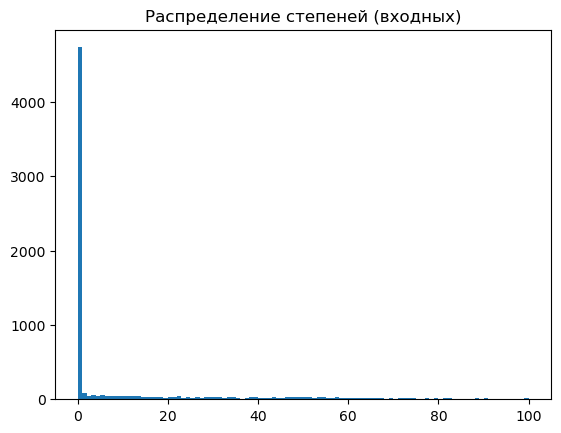

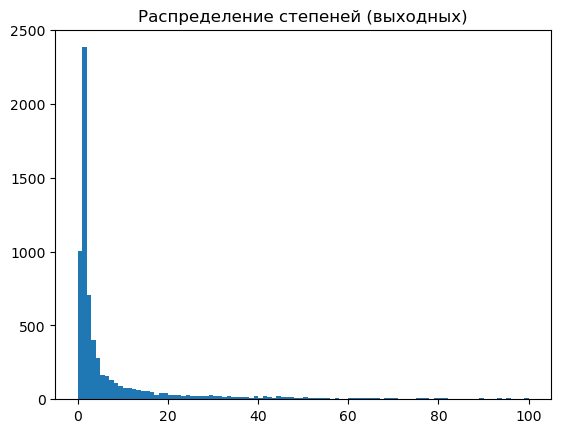

In [5]:
in_degrees = dict(G.in_degree()).values()
out_degrees = dict(G.out_degree()).values()

# Выводим распределение степеней
plt.hist(in_degrees, bins=100, range=(0, 100))
plt.title('Распределение степеней (входных)')
plt.show()

plt.hist(out_degrees, bins=100, range=(0, 100))
plt.title('Распределение степеней (выходных)')
plt.show()

**Распределения подчиняются степенному закону**

### 2)  Ассортативность (1 балл)
Вычислите ассортативность, результат представьте в ввиде матрицы, всего 4 значения для разных комбинаций in/out степеней.

In [6]:
result_matrix = np.zeros((2, 2))

# Вычисление ассортативности для разных комбинаций in/out степеней
result_matrix[0, 0] = nx.degree_assortativity_coefficient(G, "out", "out")
result_matrix[0, 1] = nx.degree_assortativity_coefficient(G, "out", "in")
result_matrix[1, 0] = nx.degree_assortativity_coefficient(G, "in", "out")
result_matrix[1, 1] = nx.degree_assortativity_coefficient(G, "in", "in")

In [7]:
pd.DataFrame(result_matrix, columns=["out", "in"], index=["out", "in"])

,out,in
out,-0.018909,-0.083245
in,0.007096,0.005091


### 3)  Связность (1 балл)
Является ли сеть сильно/слабо связанной? Постройте распределение размеров сильно связанных компонент. Сколько вершин входит в компоненту наибольшего размера?

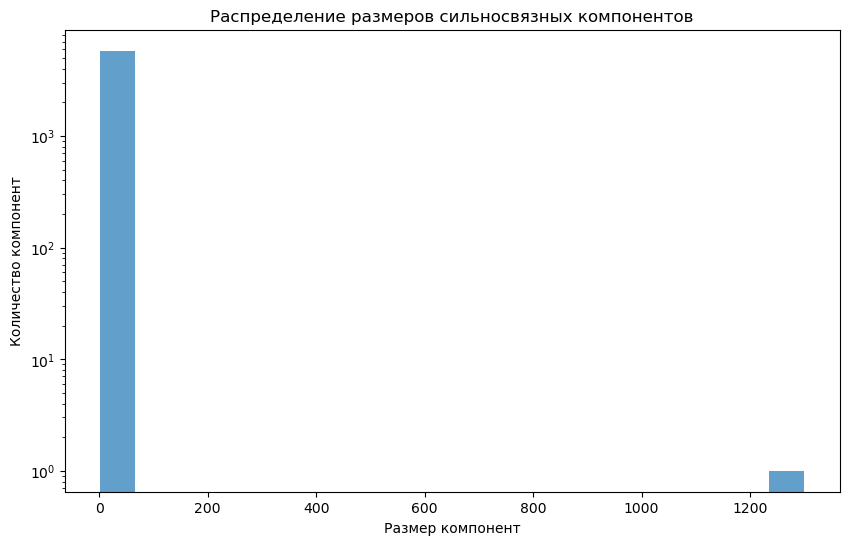

Количество вершин в наибольшей компоненте 1300


In [8]:
strongly_connected_components = list(nx.strongly_connected_components(G))

component_sizes = sorted([len(component) for component in strongly_connected_components])

plt.figure(figsize=(10, 6))
plt.hist(component_sizes, bins=20, alpha=0.7)
plt.title('Распределение размеров сильносвязных компонентов')
plt.xlabel('Размер компонент')
plt.ylabel('Количество компонент')
plt.yscale("log")
plt.show()

# Нахождение компоненты наибольшего размера
largest_component = max(strongly_connected_components, key=len)
largest_component_size = len(largest_component)

print(f"Количество вершин в наибольшей компоненте {largest_component_size}")

### 4) Кратчайшие пути (1 балл)

Определите среднюю длину кратчайшего пути в наибольшей сильно связной компоненте.

In [9]:
largest_component_graph = G.subgraph(largest_component)

# Вычисление средней длины кратчайшего пути
average_shortest_path_length = nx.average_shortest_path_length(largest_component_graph)
print(f"Cредняя длина кратчайшего пути в наибольшей сильно связной компоненте: {average_shortest_path_length}")

Cредняя длина кратчайшего пути в наибольшей сильно связной компоненте: 2.8792828803221413


## 2. Центральности и прогнозирование динамической влиятельности в направленной сети

 ### 1)  Классы (1 балл)
 Разделите вершины на два класса по значению spreading ability: "хорошо " распространяют эпидемию и "плохо".

### 2)  AUC-ROC (2 балла)
Для выбранных метрик центральности (2-3 разные меры) постройте AUC-ROC кривую и вычислите соответсвующую площадь.

### 3) Гибридная центральность (3 балла)
Для  гибридной центральности  постройте зависимость площади под AUC-ROC кривой от параметра  σ . Каков оптимальный параметр гибридной центральности?

In [10]:
load_url_content_to_file(
    url="https://drive.google.com/uc?id=1JziO7FuzyDWeUOGUNusHSPdppFodJ670",
    filename = "spreading_data_wiki-Vote.csv"
)

In [11]:
df=pd.read_csv('spreading_data_wiki-Vote.csv', dtype={"node": str})
df.head()

,node,spreading ability
0,30,0.277864
1,1412,0.000141
2,3352,0.280253
3,5254,0.278426
4,5543,0.274209


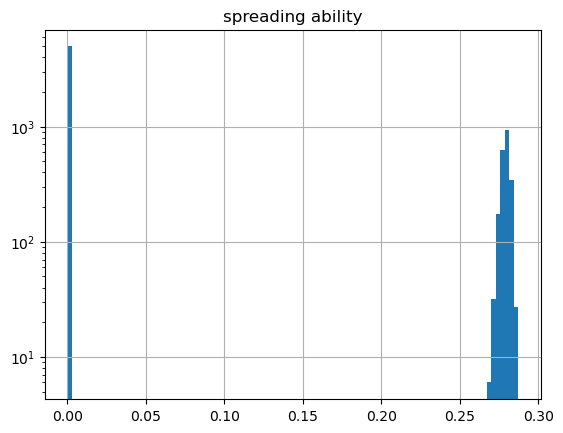

In [12]:
df.hist('spreading ability', bins=100)
plt.yscale("log")

 ### 1)  Классы (1 балл)
 Разделите вершины на два класса по значению spreading ability: "хорошо " распространяют эпидемию и "плохо".

In [13]:
# Основываясь на распределение разделим по значению 0.25

threshold = 0.25

df["target"] = (df["spreading ability"] > threshold).astype(int)

### 2)  AUC-ROC (2 балла)
Для выбранных метрик центральности (2-3 разные меры) постройте AUC-ROC кривую и вычислите соответсвующую площадь.

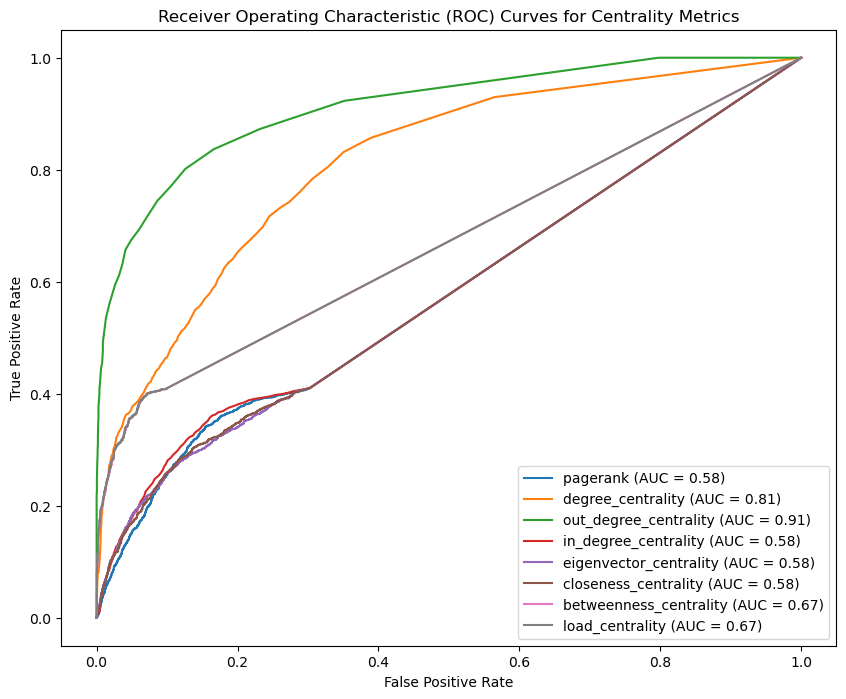

In [14]:
df["pagerank"] = df["node"].map(nx.pagerank(G))
df["degree_centrality"] = df["node"].map(nx.degree_centrality(G))
df["out_degree_centrality"] = df["node"].map(nx.out_degree_centrality(G))
df["in_degree_centrality"] = df["node"].map(nx.in_degree_centrality(G))
df["eigenvector_centrality"] = df["node"].map(nx.eigenvector_centrality(G))
df["closeness_centrality"] = df["node"].map(nx.closeness_centrality(G))
df["betweenness_centrality"] = df["node"].map(nx.betweenness_centrality(G))
df["load_centrality"] = df["node"].map(nx.load_centrality(G))

fig, ax = plt.subplots(figsize=(10, 8))

for column in df.columns[3:]:
    fpr, tpr, _ = roc_curve(df["target"], df[column])
    auc_score = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score, estimator_name=column).plot(ax=ax)

plt.title('Receiver Operating Characteristic (ROC) Curves for Centrality Metrics')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### 3) Гибридная центральность (3 балла)
Для  гибридной центральности  постройте зависимость площади под AUC-ROC кривой от параметра  σ . Каков оптимальный параметр гибридной центральности?

In [15]:
def hybrid_centrality(df: pd.DataFrame, sigma: float = 0.5) -> pd.Series:
    return (df["in_degree_centrality"] ** sigma) * (df["out_degree_centrality"] ** (1 - sigma))


,sigmas,auc
0,0.000000,0.912456
1,0.010101,0.671785
5,0.050505,0.671785
6,0.060606,0.671784
4,0.040404,0.671784
...,...,...
95,0.959596,0.663959
96,0.969697,0.663690
97,0.979798,0.663422
98,0.989899,0.663155


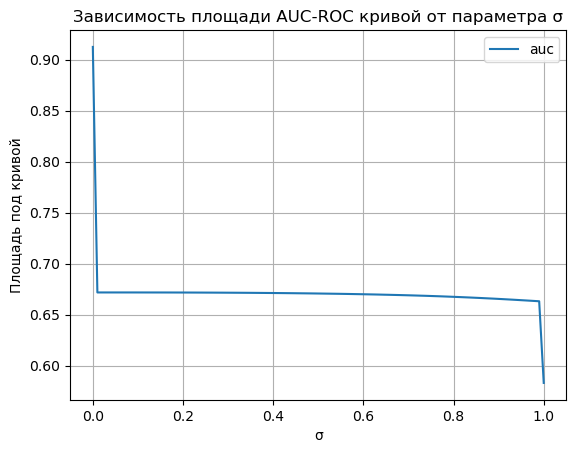

In [16]:
scores_data = []
sigmas = np.linspace(0, 1, num=100)

for sigma in sigmas:
    fpr, tpr, thresholds = roc_curve(df["target"], hybrid_centrality(df, sigma))
    roc_auc = auc(fpr, tpr)
    scores_data.append([sigma, roc_auc])

scores_df = pd.DataFrame(scores_data, columns=["sigmas", "auc"])
scores_df.plot(
    x="sigmas",
    y="auc",
    title="Зависимость площади AUC-ROC кривой от параметра σ",
    xlabel="σ",
    ylabel="Площадь под кривой",
    grid=True
)  


scores_df.sort_values(by="auc", ascending=False)

Оптимальное значение параметра **σ** равняется нулю

## 3. Моделирование направленной сети с заданным значением взаимности (доли двунаправленных связей)

### 1) Генератор (3 балла)
Напишите генератор случайного направленного графа Эрдеша-Реньи с заданной вероятностью связи $p$ и долей двунаправленных связей $r$.

 ### 2) Пример сети (1 балла)
  Для нескольких выбранных пар $(p,r)$ постройте распределение степеней, вычислите транзитивность.

 ### 3) Зависимость от $r$ (3 балла)
  Пусть $p =const$, а параметр $r$ меняется в интервале $[0,1]$. Постройте зависимость транзитивности (или средний путь) сети от параметра $r$. Объясните результаты

### 1) Генератор (3 балла)
Напишите генератор случайного направленного графа Эрдеша-Реньи с заданной вероятностью связи $p$ и долей двунаправленных связей $r$.


In [18]:
def erdos_renyi_directed_graph(n: int, p: float, r: float, tune_k = 2, seed: int = 42):
    """
    Генератор случайного направленного графа Эрдеша-Реньи.

    Параметры:
        - n: Количество узлов в графе.
        - p: Вероятность существования направленной связи.
        - r: Доля двунаправленных связей.
        - tune_k: Поправка на удаление/добавление лишних двунаправленных связей
        - seed: cид, чтобы контролировать рандом при пересоздании графа с одинаковыми параметрами

    Возвращает:
        - G: Направленный граф Эрдеша-Реньи.
    """
    
    random.seed(seed)
    
    G = nx.DiGraph()
    
    G.add_nodes_from(range(n))

    for u in range(n):
        for v in range(u + 1, n):
            if random.uniform(0, 1) < p:
                G.add_edge(u, v)
                if random.uniform(0, 1) < r:
                    G.add_edge(v, u)
    
    reciprocity = nx.reciprocity(G)

    if reciprocity > r:
        edges = G.edges()
        excess_reciprocity_count = int((len(edges)*reciprocity - r) // (r*10+tune_k)) 
        bidirectional_edges = [(u, v) for u, v in edges if G.has_edge(v, u)]
        G.remove_edges_from(random.sample(bidirectional_edges, excess_reciprocity_count))
    elif reciprocity < r:
        edges = G.edges()
        missing_reciprocity_count = int((r - len(edges)*reciprocity - r) // (r*10+tune_k)) 
        onedirectional_edges = [(u, v) for u, v in edges if not G.has_edge(v, u)]
        to_add_bidirectional_edges = random.sample(onedirectional_edges, missing_reciprocity_count)
        for edge in to_add_bidirectional_edges:
            G.add_edge(edge[1], edge[0])      
    
    return G

# Пример использования
n = 1000  # количество вершин
p = 0.3  # вероятность направленного ребра
r = 0.2 # доля двунаправленных связей

test_G = erdos_renyi_directed_graph(n, p, r)

In [19]:
print(f"Доля двунаправленных связей: {nx.reciprocity(test_G)}")

Доля двунаправленных связей: 0.20285667457826717


### 2) Пример сети (1 балла)
  Для нескольких выбранных пар $(p,r)$ постройте распределение степеней, вычислите транзитивность.

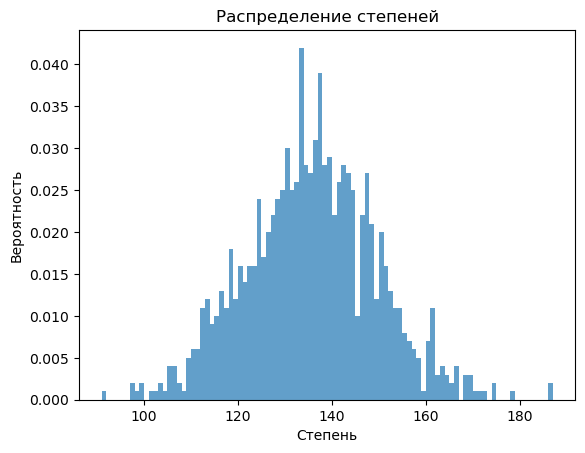

p=0.1, r=0.5, Транзитивность=0.06766354991518797


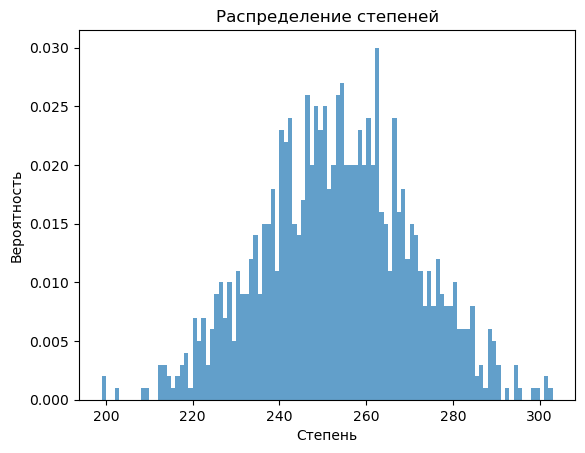

p=0.2, r=0.4, Транзитивность=0.1264594291010311


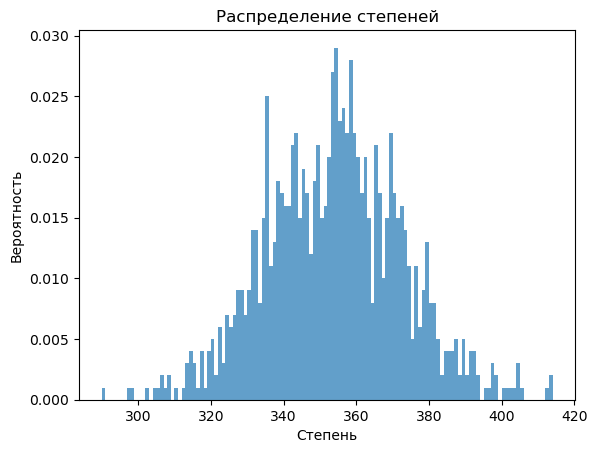

p=0.3, r=0.3, Транзитивность=0.17663918520646388


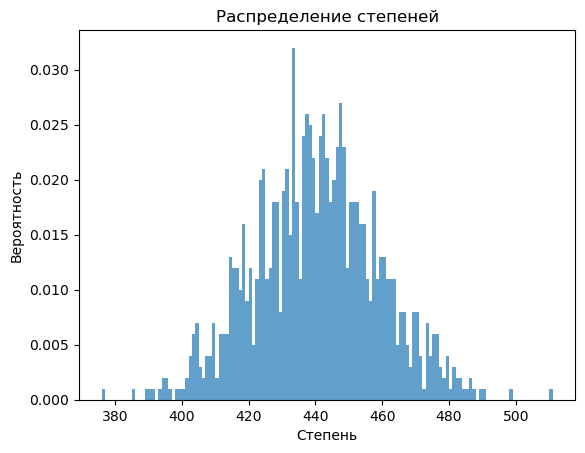

p=0.4, r=0.2, Транзитивность=0.22030251451240546


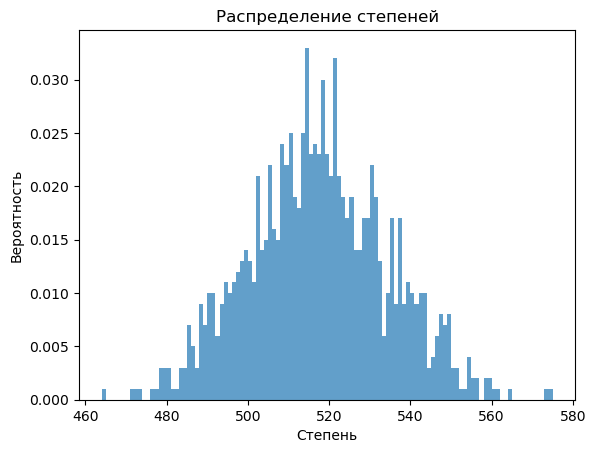

p=0.5, r=0.1, Транзитивность=0.25896714823279965


In [20]:
def analyze_graph(G: nx.classes.digraph.DiGraph):
    # Распределение степеней
    degrees = [degree for node, degree in G.degree()]
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 1), density=True, alpha=0.7)
    plt.title("Распределение степеней")
    plt.xlabel("Степень")
    plt.ylabel("Вероятность")
    plt.show()

    # Транзитивность
    transitivity = nx.transitivity(G)
    print(f"p={p}, r={r}, Транзитивность={nx.transitivity(G)}")

n = 1000
# Выбранные параметры p и r
params_list = [(0.1, 0.5), (0.2, 0.4), (0.3, 0.3), (0.4, 0.2), (0.5, 0.1)]  # Примеры параметров

for p, r in params_list:
    graph = erdos_renyi_directed_graph(n=n, p=p, r=r)
    analyze_graph(graph)

 ### 3) Зависимость от $r$ (3 балла)
  Пусть $p =const$, а параметр $r$ меняется в интервале $[0,1]$. Постройте зависимость транзитивности (или средний путь) сети от параметра $r$. Объясните результаты

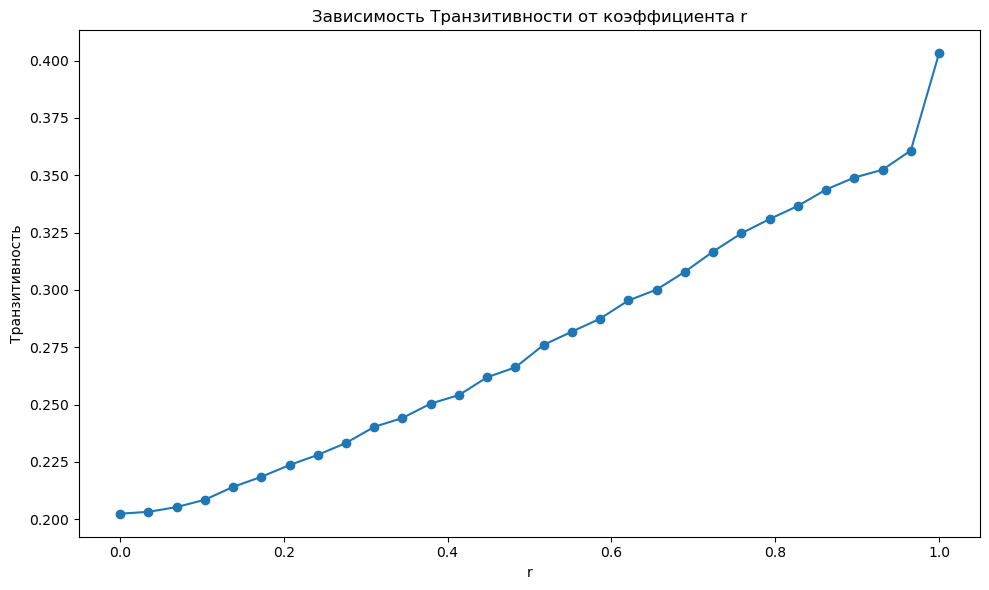

In [21]:
# Параметры p и диапазон значений r
p = 0.4
r_values = np.linspace(0, 1, num=30)

# Списки для сохранения результатов
transitivity_values = []

# Создание графов и вычисление метрик
for r in r_values:
    graph = erdos_renyi_directed_graph(100, p, r)
    transitivity_values.append(nx.transitivity(graph))
    
# Построение графика
plt.figure(figsize=(10, 6))

plt.plot(r_values, transitivity_values, marker='o')
plt.title("Зависимость Транзитивности от коэффициента r")
plt.xlabel("r")
plt.ylabel("Транзитивность")


plt.tight_layout()
plt.show()

**Вывод:** При увеличении значения r (доли двусторонних связей) в графе увеличивается количество двусторонних связей, что может способствовать появлению транзитивных троек. Таким образом, возможно увеличение транзитивности графа.